In [1]:
import tensorflow as tf
from tensorflow.python.keras import Input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.engine.keras_tensor import KerasTensor
from tensorflow.python.keras.engine.functional import Functional
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.python.keras.regularizers import l1, l2
import os

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning, prune_low_magnitude

from callbacks import all_callbacks


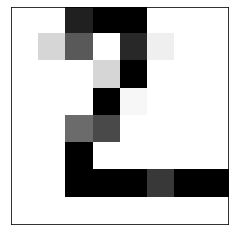

In [2]:
import MNIST_dataset as mnist

#Choose the final size of your image dataset
size_final = 8

data_zoom = mnist.MNISTData(size_initial=20, size_final=size_final, color_depth=5, flat=True)
test= data_zoom.x_test
ax = plt.subplot(1, 1 , 1)

plt.imshow(test[1].reshape(size_final,size_final), cmap='gray_r')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [26]:
#lista contenente gli indici delle immagini campione nel Test Set del MNIST
#num_list[0] contiene l'indice dell'immagine di uno zero, num_list[1] di un uno e così via
#           0  1  2  3  4  5  6  7  8  9 
num_list = [3, 2, 1, 32,4, 15,21,0, 61,12]


#---------------------------------------------------------
#--FORMAT OF INPUT IMAGES FOR NN IN FPGA------------------
#----------- ap_fixed<6,0> -------------------------------
#---------------------------------------------------------

# last pixel              first pixel
#[0  1  0  0  0  0 | ... | 0  0  0  1  0  0]
# s  4  3  2  1  0         s  4  3  2  1  0 
#    2  2  2  2  2            2  2  2  2  2  


with open('TESTimg_downto_apfixed6.txt', 'w') as f:
    for index , num in enumerate(num_list):
        f.write(str(index)+ ': ')
        for i in np.flip(test[num]):
            f.write('{:06d}'.format(int((bin(int(i*256/4))[2:]))))
            #print(int((bin(int(i*256/4))[2:])))
        f.write('\n\n')


In [17]:
print(np.flip(test[0]*256/4))


#print(np.flip(test[0]*256))

[ 0.  0.  0.  0. 62.  0.  0.  0.  0.  0.  0. 50.  6.  0.  0.  0.  0.  0.
  6. 46.  0.  0.  0.  0.  0.  0. 62.  0.  0.  0.  0.  0.  0.  8. 38.  0.
  0.  0.  0.  0.  0. 58. 34. 46. 44. 14. 12.  0.  0.  0.  0.  0.  0. 16.
 28.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [60]:
#lista contenente gli indici delle immagini campione nel Test Set del MNIST
#num_list[0] contiene l'indice dell'immagine di uno zero, num_list[1] di un uno e così via

n_image_test = 100

#           0  1  2  3  4  5  6  7  8  9          
num_list = [3, 2, 1, 32,4, 15,21,0, 61,12] + [x for x in range(62,62 + n_image_test - 10)]


with open('TESTimg_downto_apfixed6_100.txt', 'w') as f:
    for index , num in enumerate(num_list):
        f.write('signal address_' + str(index) + ' : std_logic_vector((size-1) downto 0) := \n')
        for i in np.flip(test[num]):
            f.write('{:06d}'.format(int((bin(int(i*256/4))[2:]))))
        f.write('\n\n')

from tensorflow.keras.datasets import mnist
(X_train, y_train_int), (X_test, y_test_int) = mnist.load_data()

#salvataggio dei true label associati alle immagini inserite nella FPGA
with open('TESTlabels_downto_apint6_100imgs.txt', 'w') as f:
    for index , num in enumerate(num_list):
        f.write('signal label_' + str(index) + ' : std_logic_vector(3 downto 0) :=  ')
        f.write('{:04d}'.format(int((bin(y_test_int[num])[2:]))))
        f.write('\n')

In [52]:
print(data_zoom.y_test)
for i in data_zoom.y_test:
    data_zoom

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [54]:
from tensorflow.keras.datasets import mnist
(X_train, y_train_int), (X_test, y_test_int) = mnist.load_data()
print(y_test_int)

[7 2 1 ... 4 5 6]


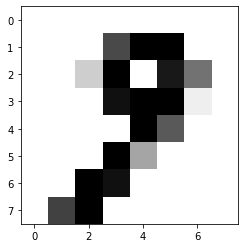

In [58]:
plt.imshow(test[num_list[21]].reshape(size_final,size_final), cmap='gray_r')
